# 多智能体强化学习进阶

教程链接：[多智能体强化学习进阶](https://hrl.boyuai.com/chapter/3/%E5%A4%9A%E6%99%BA%E8%83%BD%E4%BD%93%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0%E8%BF%9B%E9%98%B6)

**中心化训练去中心化执行**（centralized training with decentralized execution，CTDE）是指在训练的时候使用一些单个智能体看不到的全局信息而以达到更好的训练效果，而在执行时不使用这些信息，每个智能体完全根据自己的策略直接动作以达到去中心化执行的效果。中心化训练去中心化执行的算法能够在训练时有效地利用全局信息以达到更好且更稳定的训练效果，同时在进行策略模型推断时可以仅利用局部信息，使得算法具有一定的扩展性。

CTDE 可以类比成一个足球队的训练和比赛过程：在训练时，11 个球员可以直接获得教练的指导从而完成球队的整体配合，而教练本身掌握着比赛全局信息，教练的指导也是从整支队、整场比赛的角度进行的；而训练好的 11 个球员在上场比赛时，则根据场上的实时情况直接做出决策，不再有教练的指导。

CTDE 算法主要分为两种：一种是基于值函数的方法，例如 VDN，QMIX 算法等；另一种是基于 Actor-Critic 的方法，例如 MADDPG 和 COMA 等。

## 0. 环境介绍

我们要使用的环境为多智能体粒子环境（multiagent particles environment，MPE），它是一些面向多智能体交互的环境的集合，在这个环境中，粒子智能体可以移动、通信、“看”到其他智能体，也可以和固定位置的地标交互。

接下来安装环境，由于 MPE 的官方仓库的代码已经不再维护了，而其依赖于 gym 的旧版本，因此我们需要重新安装 gym 库。

In [1]:
!git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
!pip install -e multiagent-particle-envs -q

fatal: destination path 'multiagent-particle-envs' already exists and is not an empty directory.


In [2]:
# 由于multiagent-pariticle-env底层的实现有一些版本问题,因此gym需要改为可用的版本
!pip install --upgrade gym==0.10.5 -q

In [3]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils

In [4]:
import sys
sys.path.append("multiagent-particle-envs")

import gym
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

In [5]:
def make_env(scenario_name:str) -> MultiAgentEnv:
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

## 1. MADDPG 算法

**多智能体 DDPG**（muli-agent DDPG，MADDPG）算法从字面意思上来看就是对于每个智能体实现一个 DDPG 的算法。所有智能体共享一个中心化的 Critic 网络，该 Critic 网络在训练的过程中同时对每个智能体的 Actor 网络给出指导，而执行时每个智能体的 Actor 网络则是完全独立做出行动，即去中心化地执行。

需要说明的是，MPE 环境中的每个智能体的动作空间是离散的。 DDPG 算法本身需要使智能体的动作对于其策略参数可导，这对连续的动作空间来说是成立的，但是对于离散的动作空间并不成立（离散分布的采样不可求导）。但这并不意味着当前的任务不能使用 MADDPG 算法求解，因为我们可以使用一个叫作 Gumbel-Softmax 的重参数化方法来得到离散分布的近似采样。

定义一些需要用到的工具函数，其中包括让 DDPG 可以适用于离散动作空间的 Gumbel Softmax 采样的相关函数。

In [6]:
def onehot_from_logits(
        logits:th.Tensor, eps:float=0.01
    ) -> th.Tensor:
    ''' 生成最优动作的独热 (one-hot) 形式 '''
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作,转换成独热形式
    rand_acs = th.autograd.Variable(
                th.eye(logits.shape[1])[[
                    np.random.choice(range(logits.shape[1]), size=logits.shape[0])
                ]],
                requires_grad=False
            ).to(logits.device)
    # 通过epsilon-贪婪算法来选择用哪个动作
    return th.stack([
            argmax_acs[i] if r > eps else rand_acs[i]
            for i, r in enumerate(th.rand(logits.shape[0]))
        ])


def sample_gumbel(
        shape:th.Size, eps:float=1e-20, tens_type=th.FloatTensor
    ) -> th.Tensor:
    """从Gumbel(0,1)分布中采样"""
    U = th.autograd.Variable(tens_type(*shape).uniform_(), requires_grad=False)
    return -th.log(-th.log(U + eps) + eps)


def gumbel_softmax_sample(
        logits:th.Tensor, temperature:float
    ) -> th.Tensor:
    """ 从Gumbel-Softmax分布中采样"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)
                                ).to(logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(
        logits:th.Tensor, temperature:float=1.0
    ) -> th.Tensor:
    """
    从Gumbel-Softmax分布中采样,并进行离散化。
    返回一个y_hard的独热量, 但是它的梯度是y, 我们既能够得到一个与环境交互的离散动作,
    又可以正确地反传梯度
    """
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    return y

接着实现我们的单智能体 DDPG。其中包含 Actor 网络与 Critic 网络，以及计算动作的函数。但这里没有更新网络参数的函数，其将会在 MADDPG 类中被实现。

In [7]:
class TwoLayerFC(nn.Module):
    def __init__(self, num_in:int, num_out:int, hidden_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(num_in, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_out)

    def forward(self, x:th.Tensor) -> th.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, 
            state_dim:int, action_dim:int, critic_input_dim:int, hidden_dim:int,
            actor_lr:float, critic_lr:float, device:th.device
        ):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(),
                                        lr=actor_lr)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(),
                                        lr=critic_lr)

    def take_action(self, state:th.Tensor, explore:bool=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(
                param_target.data * (1.0 - tau) + param.data * tau
            )

接下来正式实现一个 MADDPG 类，该类对于每个智能体都会维护一个 DDPG 算法。

In [8]:
class MADDPG:
    def __init__(self, 
            env, device:th.device, actor_lr:float, critic_lr:float, 
            hidden_dim:int, state_dims:list[int], action_dims:list[int], critic_input_dim:int, 
            gamma:float, tau:float
        ):
        self.env = env
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device)
            )
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = th.nn.MSELoss()
        self.device = device

    @property
    def policies(self) -> list:
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self) -> list:
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states:th.Tensor, explore:bool) -> list:
        states = [
            th.tensor([states[i]], dtype=th.float, device=self.device)
            for i in range(len(self.env.agents))
        ]
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample:tuple, i_agent:int):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]
        target_critic_input = th.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(-1, 1) + \
                            self.gamma * cur_agent.target_critic(target_critic_input
                                                ) * (1 - done[i_agent].view(-1, 1))
        critic_input = th.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(
                        critic_value, target_critic_value.detach()
                    )
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = th.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

定义一些超参数，创建环境、智能体以及经验回放池并准备训练。

In [9]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = th.device("cuda" if th.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:
    action_dims.append(action_space.n)
for state_space in env.observation_space:
    state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

接下来实现以下评估策略的方法，之后就可以开始训练了！

In [10]:
def evaluate(
        env_id:str, maddpg:MADDPG, n_episode:int=10, episode_length:int=25
    ) -> list:
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size() >= minimal_size and \
           total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)

            def stack_array(x) -> list:
                rearranged = [[sub_x[i] for sub_x in x]
                              for i in range(len(x[0]))]
                return [
                    th.FloatTensor(np.vstack(aa)).to(device)
                    for aa in rearranged
                ]

            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(env_id, maddpg, n_episode=100)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

/tmp/ipykernel_3446012/2883626405.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  th.tensor([states[i]], dtype=th.float, device=self.device)


Episode: 100, [-34.335171142942194, -0.763461326540244, -0.763461326540244]


/data3/djp/rvo2/learn-rl/前沿篇/rl_utils.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(state), action, reward, np.array(next_state), done


Episode: 200, [-164.77028064776877, 6.1108276677586275, 6.1108276677586275]
Episode: 300, [-40.391016131295395, 2.570898570577302, 2.570898570577302]
Episode: 400, [-74.73735593124262, -3.707389601204239, -3.707389601204239]
Episode: 500, [-15.084802465771979, 1.962572561055457, 1.962572561055457]
Episode: 600, [-13.38308097704197, 4.3000866051992634, 4.3000866051992634]
Episode: 700, [-14.561657518342626, 3.7118956217096764, 3.7118956217096764]
Episode: 800, [-11.918005348094756, 5.248323470112564, 5.248323470112564]
Episode: 900, [-12.327841460079124, 7.264982553236236, 7.264982553236236]
Episode: 1000, [-11.582191704148403, 8.301602538703213, 8.301602538703213]
Episode: 1100, [-10.042180479438711, 6.8866426140491415, 6.8866426140491415]
Episode: 1200, [-9.28276476427195, 6.7120955586513595, 6.7120955586513595]
Episode: 1300, [-9.465400000035538, 7.789190979278872, 7.789190979278872]
Episode: 1400, [-8.447427978880512, 6.523814347926937, 6.523814347926937]
Episode: 1500, [-8.11548221

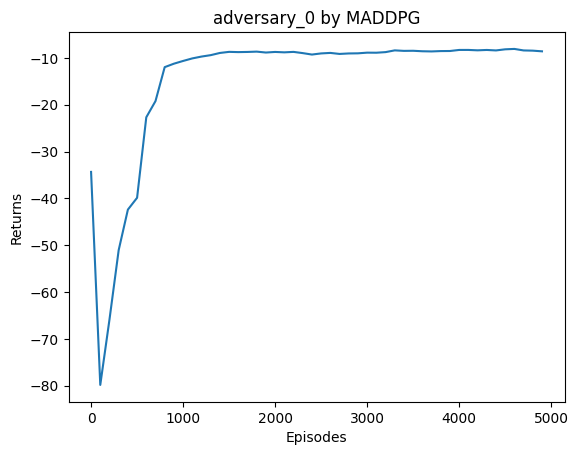

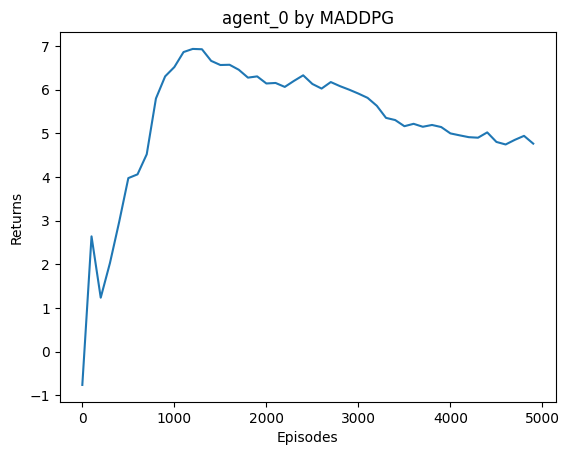

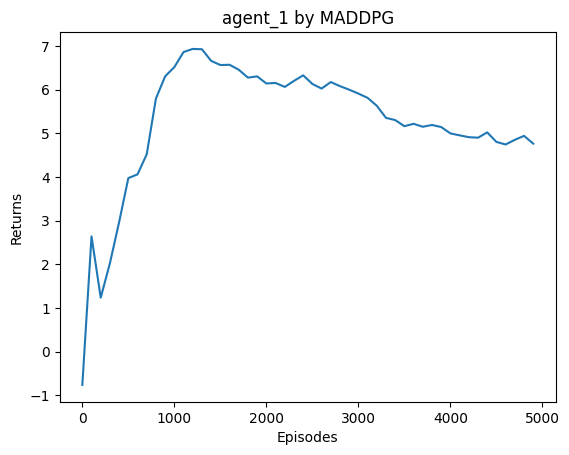

In [11]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(
        np.arange(return_array.shape[0]) * 100,
        rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

可以看到，正常智能体`agent_0`和`agent_1`的回报结果完全一致，这是因为它们的奖励函数完全一样。正常智能体最终保持了正向的回报，说明它们通过合作成功地占领了两个不同的地点，进而让对抗智能体无法知道哪个地点是目标地点。另外，我们也可以发现 MADDPG 的收敛速度和稳定性都比较不错。